<a href="https://colab.research.google.com/github/MaslovAleksey/Determination-of-the-car-brand/blob/main/Determination_of_the_car_brand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Определение марки автомобиля по изображению** 

## **1.) Техническое описание** 



* ### **Постановка задачи:**
> #### Необходимо по изображению автомобиля определить его марку из имеющегося перечня различных вариантов.

---

* ### **Используемые библиотеки и классы:**
> #### keras, numpy, matplotlib, Image, SimpleNamespace, random, math, os.

---

* ### **Особенности реализации:**
> #### 1.   Для аугментации и хранения изображений используется *ImageDataGenerator*;
> #### 2.   Слои, формирующие архитектуру нейронной сети: *Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Input*;
> #### 3.   Каждый свёрточный блок состоит из *BatchNormalization, Conv2D, Conv2D, MaxPooling2D, Dropout*;
> #### 4.   Конфигурация данных формируется на основании пользовательского ввода и храниться в экземпляре класса *SimpleNamespace*




## **2.) Подготовка данных**

### **Подключение необходимых библиотек**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator # работа с изображениями
from tensorflow.keras.optimizers import Adam, Adadelta # оптимизаторы
from tensorflow.keras import utils 
from tensorflow.keras.preprocessing import image # отрисовка изображений
from tensorflow.keras.callbacks import ModelCheckpoint

from google.colab import files
import numpy as np 
import matplotlib.pyplot as plt # отрисовка графиков
from PIL import Image # отрисовка изображений
import random  
import math
import os 
from types import SimpleNamespace # подкласс object, позволяющий добавлять и удалять атрибуты
from google.colab import drive
%matplotlib inline

### **Загрузка изображений с Google-диска**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/My Drive/Colab Notebooks/UAI/3.) Convolutional neural networks/Data/Автомобили.zip' # извлечение файлов из архива

### **Глобальные переменные**

In [ ]:
auto_path = '/content/Автомобили'
car_names = os.listdir(auto_path)[::-1] # располагаем марки автомобилей в порядке следования

num = len(car_names) # количесво классов автомобилей
class_mode = "binary" if (num == 2) else "categorical" # тип выборки

img_width = 243 # ширина изображения
img_height = 162 # высота изображения
num_chnls = 3 # число каналов

### **Демонстрация изображений из набора**

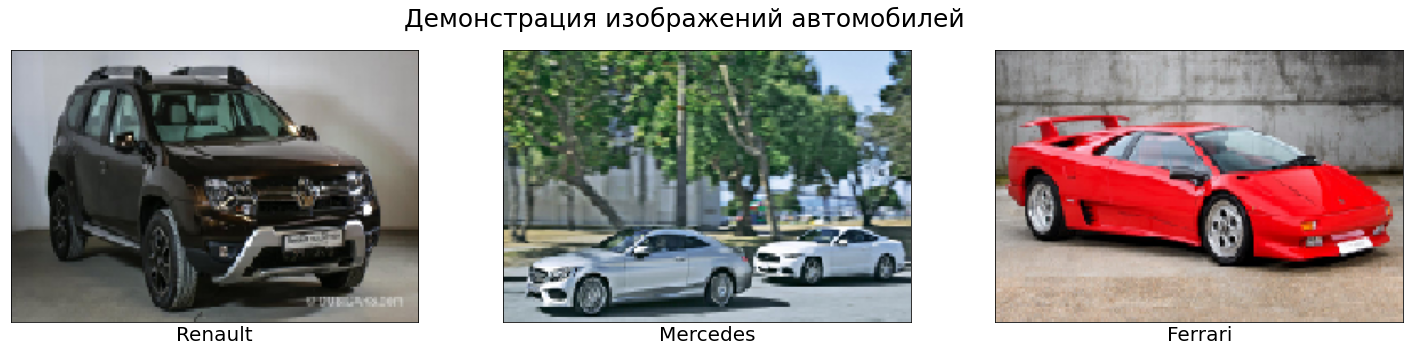

In [ ]:
fig, ax = plt.subplots(1, num, figsize=(25, 5)) # создание полотна из k графиков
fig.suptitle("Демонстрация изображений автомобилей", y=1, size=25)

for i in range(num): 
  car_path = auto_path + '/' + car_names[i] + '/' # формирование путя к выборке
  img_path = car_path + random.choice(os.listdir(car_path)) # выбор случайного фото для отображения
  

  ax[i].imshow(image.load_img(img_path, target_size=(img_height, img_width))) #Отображение фотографии

  ax[i].axes.xaxis.set_ticks([]) # инициализация тиков и меток оси пустым списком
  ax[i].get_yaxis().set_visible(False)
  ax[i].set_xlabel(car_names[i], size=20)

plt.show() # демонстрация изображений

## **2.) Необходимые функции**

### **Конфигурация данных**

In [ ]:
def create_config():
  config = SimpleNamespace()

  config.batch_size = int(input("Batch size - "))
  config.validation_split = int(input("Процент проверочной выборки - "))
  
  config.rotation_range = int(input("Поворот изображения (в градусах) - "))
  config.width_shift_range = float(input("Смещение изображения по ширине  [-1.0, +1.0) - "))
  config.height_shift_range = float(input("Смещение изображения по высоте  [-1.0, +1.0) - "))
  config.zoom_range = float(input("Коэффициент зуммирования [0.0, +1.0] - "))
  config.horizontal_flip = input("Случайное отображение относительно горизонтали (Да/Нет) - ")
  config.vertical_flip = input("Случайное отображение относительно вертикали (Да/Нет) - ")
  config.shuffle_train = input("Перемешивание тренировочной выборки (Да/Нет) - ")
  config.shuffle_val = input("Перемешивание проверочной выборки (Да/Нет) - ")

  return config

### **Формирование наборов данных**

In [ ]:
def create_data(config):
  #Генератор изображений
  datagen = ImageDataGenerator(
    rescale = 1. / 255, # нормализация изображения
    rotation_range = config.rotation_range, # поворот изображения при генерации выборки
    width_shift_range = config.width_shift_range, # смещение изображения по ширине при генерации выборки
    height_shift_range = config.height_shift_range, # смещение изображения по высоте при генерации выборки
    zoom_range = config.zoom_range, # зумирование изображения при генерации выборки
    horizontal_flip = True if config.horizontal_flip == "Да" else False, # отражение изображений относительно горизонтали
    vertical_flip = True if config.vertical_flip == "Да" else False, # отражение изображений относительно вертикали
    fill_mode = 'nearest', # заполнение пикселей вне границ ввода
    validation_split = config.validation_split / 100
    ) # разделение изображений на обучающую и тестовую выборку

  # Обучающая выборка
  train_generator = datagen.flow_from_directory(
    directory = auto_path, # путь ко всей выборке выборке
    target_size = (img_height, img_width), # размер изображений
    batch_size = config.batch_size, # размер batch_size
    class_mode = class_mode, # тип выборки 
    shuffle = True if config.shuffle_train == "Да" else False, # перемешивание выборки
    subset = 'training'
    )
  
  # Проверочная выборка
  val_generator = datagen.flow_from_directory(
    directory = auto_path, # путь ко всей выборке выборке
    target_size = (img_height, img_width), # размер изображений
    batch_size = config.batch_size, # размер batch_size
    class_mode = class_mode, # тип выборки 
    shuffle = True if config.shuffle_val == "Да" else False, # перемешивание выборки
    subset = 'validation'
    )
  
  return train_generator, val_generator

### **Архитектура нейронной сети**

In [ ]:
'''
  Особенности архитектуры:

  1.) Нейронная сеть представляет собой последовательность аналогичных
свёрточных блоков, состоящих из следующих слоёв:
- BatchNormalization()
- Conv2D(...)
- Conv2D(...)
- MaxPooling2D(...)
- Dropout(...)

  2.) Число свёрточных фильтров возрастает в 2 раза при переходе к слудующему блоку
'''

def create_network(num_blocks, num_filters, rate):
  
  # Параметры Conv2D()
  curr_filters = num_filters # текущее число свёрточных фильтров
  kernel_size = (3,3) 
  conv_strides = (1,1) 
  conv_padding = "same"
  conv_actiavation = "relu"

  # Параметры MaxPooling2D()
  pool_size = (3,3)
  pool_strides = (3,3)
  pool_padding = "valid"

  input = Input(shape=(img_height, img_width, num_chnls)) # входной слой

  # Формирование свёрточных блоков
  for k in range(num_blocks):
    if k == 0:
      b = BatchNormalization()(input)
    else:
      b = BatchNormalization()(drop)
    conv = Conv2D(filters=curr_filters, kernel_size=kernel_size, strides=conv_strides, padding=conv_padding, activation=conv_actiavation)(b)
    conv = Conv2D(filters=curr_filters, kernel_size=kernel_size, strides=conv_strides, padding=conv_padding, activation=conv_actiavation)(conv)
    pool = MaxPooling2D(pool_size=pool_size, strides=pool_strides, padding=pool_padding)(conv)
    drop = Dropout(rate = rate)(pool)

    curr_filters *= 2 # увеличение числа свёрточных фильтров
  
  # Полносвязный блок
  x = Flatten()(drop)
  x = Dense(units=2048)(x)
  x = Dropout(rate=rate)(x)
  x = Dense(units=512)(x)  
  x = Dropout(rate=rate)(x)

  output = Dense(units=num, activation="softmax")(x)

  conv_model = Model(inputs = input, outputs = output)

  return conv_model  

### **Релизация Callback**

In [ ]:
def get_callback(saved_file):
  # saved_file = "autoencoders.h5"
  best_weights = ModelCheckpoint(
    saved_file,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True
    )
  
  return best_weights

### **Визуализация процесса обучения**

In [ ]:
def training_visual(history):
  fig, ax = plt.subplots(figsize=(12,7))
  ax.set_title("Ошибка в процессе обучения", size=16, pad=20)
  ax.plot(history.history["loss"], label="тренировочные данные")
  ax.plot(history.history["val_loss"], label="проверочные данные")
  ax.set_xlabel("Число эпох", size=12)
  ax.set_ylabel("Categorical crossentropy", size=12)
  ax.legend(prop={"size":12})
  plt.show()
  
  fig, ax = plt.subplots(figsize=(12,7))
  ax.set_title("Точность в процессе обучения", size=16, pad=20)
  ax.plot(history.history["accuracy"], label="тренировочные данные")
  ax.plot(history.history["val_accuracy"], label="проверочные данные")
  ax.set_xlabel("Число эпох", size=12)
  ax.set_ylabel("Accuracy", size=12)
  ax.legend(prop={"size":12})
  plt.show()

### **Тренировка нейронной сети**

In [ ]:
def model_training(conv_model, initial_epoch, epochs, learning_rate, bool_callback):

  # Число шагов на эпоху
  steps_per_epoch = len(train_generator)
  val_steps = len(val_generator)

  # Исрользование callback для сохранения весов
  if bool_callback == "Да":
    saved_file = f"conv_model_lr_{learning_rate}_ep_{initial_epoch}_{epochs}.h5"
    callback = get_callback(saved_file)
  else:
    callback = None

  
  # Компиляция модели
  conv_model.compile(
      loss = 'categorical_crossentropy',
      optimizer = Adam(learning_rate=learning_rate),
      metrics = ['accuracy']
  )

  # Процесс обучения
  history = conv_model.fit_generator(
    generator = train_generator,
    steps_per_epoch = steps_per_epoch,
    validation_data = val_generator, 
    validation_steps = val_steps,
    callbacks = callback,
    epochs = epochs,
    verbose=1,
    initial_epoch = initial_epoch
    )
  
  #Визуализация результатов обучения
  training_visual(history)

### **Тестирование алгоритма**

In [ ]:
def determine_auto(model, num_img, use_weights, path_weights):

  # Загрузка весов модели
  if (use_weights == "Да"):
    model.load_weights(path_weights)

  fig, ax = plt.subplots(1, num, figsize=(25, 5)) # создание полотна из k графиков
  fig.suptitle("Оценка качества работы нейронной сети", y=1, size=25)

  for i in range(num_img):
    real_name_auto = car_names[i % num] # выбор марки очередного автомобиля
    path_auto_class = auto_path + '/' + real_name_auto + '/' # путь к папке автомобилей выбранной марки
    path_auto = path_auto_class + random.choice(os.listdir(path = path_auto_class)) # путь к случайно выбранному изображению

    img = image.load_img(path_auto, target_size=(img_height, img_width)) # загрузка изображения
    img_arr = image.img_to_array(img) / 255. # img -> array
    img_arr = np.expand_dims(img_arr, axis = 0) # увеличение размерности -> (1, img_width, img_height, num_chnls)
    
    pred = np.squeeze(model.predict(img_arr)) # предсказание нейронной сети
    pred_name_auto = car_names[np.argmax(pred, axis=0)]

    x_label = f"Марка авто - {real_name_auto}\n Предсказание нейронной сети - {pred_name_auto}"

    ax[i].imshow(img) 

    ax[i].axes.xaxis.set_ticks([]) # инициализация тиков и меток оси пустым списком
    ax[i].get_yaxis().set_visible(False)
    ax[i].set_xlabel(x_label, size=20)

  plt.show() # демонстрация изображений

## **3.) Реализация алгоритма классификации** 

### **Формирование наборов данных**

In [ ]:
config = create_config() # конфигурация данных

Batch size - 8
Процент проверочной выборки - 20
Поворот изображения (в градусах) - 10
Смещение изображения по ширине  [-1.0, +1.0) - 0.1
Смещение изображения по высоте  [-1.0, +1.0) - 0.1
Коэффициент зуммирования [0.0, +1.0] - 0.1
Случайное отображение относительно горизонтали (Да/Нет) - Да
Случайное отображение относительно вертикали (Да/Нет) - Да
Перемешивание тренировочной выборки (Да/Нет) - Да
Перемешивание проверочной выборки (Да/Нет) - Да


In [ ]:
train_generator, val_generator = create_data(config) # формирование выборок

Found 2743 images belonging to 3 classes.
Found 684 images belonging to 3 classes.


In [ ]:
print(f"Размер тренировочгой выборки - {train_generator.samples}")
print(f"Размер проверочной выборки - {val_generator.samples}")
print(f"Размерность батча - {val_generator[0][0].shape}")

Размер тренировочгой выборки - 2743
Размер проверочной выборки - 684
Размерность батча - (8, 162, 243, 3)


### **Создание нейронной сети** 

In [ ]:
num_blocks = int(input("Число свёрточных блоков (не более 5) - "))
num_filters = int(input("Количество фильтров на 1-м свёрточном слое - "))
rate = float(input("Коэффициент отключения нейронов (dropout rate) [0; 1] - "))

Число свёрточных блоков (не более 5) - 4
Количество фильтров на 1-м свёрточном слое - 128
Коэффициент отключения нейронов (dropout rate) [0; 1] - 0.35


In [ ]:
conv_model = create_network(num_blocks, num_filters, rate)

Архитектура нейронной сети


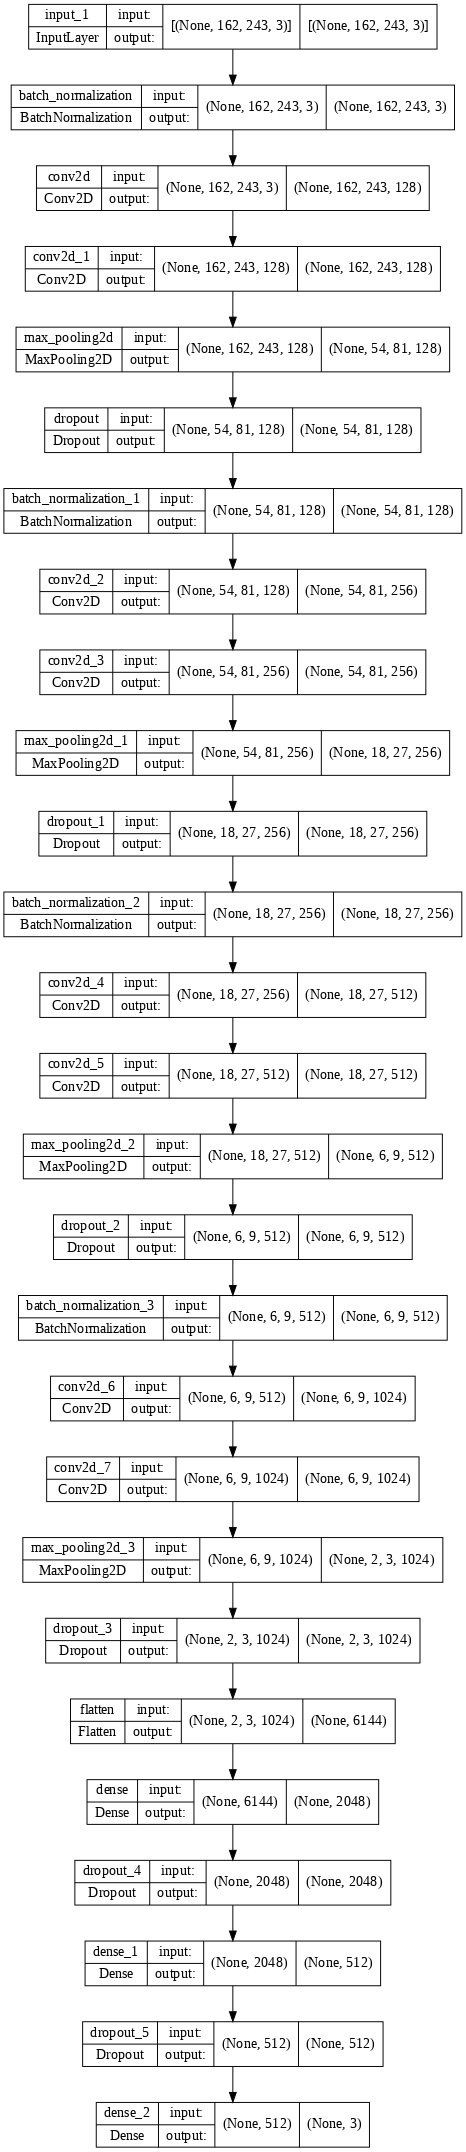

In [ ]:
print("Архитектура нейронной сети")
utils.plot_model(conv_model, show_shapes=True, dpi=70)

In [ ]:
print("Структура модели")
conv_model.summary()

Структура модели
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 162, 243, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 162, 243, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 162, 243, 128)     3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 162, 243, 128)     147584    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 54, 81, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 54, 81, 

### **Обучение модели**

In [ ]:
epochs = int(input("Количество эпох обучения - "))
initial_epoch = int(input("Стартовая эпоха обучения - "))
learning_rate = float(input("Шаг обучения - "))
bool_callback = (input("Необходимо ли сохранять веса с наилучшими показателями? (Да/Нет) - "))

Количество эпох обучения - 70
Стартовая эпоха обучения - 0
Шаг обучения - 1e-4
Необходимо ли сохранять веса с наилучшими показателями? (Да/Нет) - Да


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/70
343/343 [==============================] - 77s 183ms/step - loss: 1.6868 - accuracy: 0.4397 - val_loss: 1.0911 - val_accuracy: 0.3480
Epoch 2/70
343/343 [==============================] - 60s 175ms/step - loss: 0.9982 - accuracy: 0.5024 - val_loss: 1.0017 - val_accuracy: 0.4971
Epoch 3/70
343/343 [==============================] - 61s 176ms/step - loss: 0.9454 - accuracy: 0.5283 - val_loss: 0.9692 - val_accuracy: 0.4912
Epoch 4/70
343/343 [==============================] - 59s 173ms/step - loss: 0.9267 - accuracy: 0.5461 - val_loss: 1.0843 - val_accuracy: 0.4678
Epoch 5/70
343/343 [==============================] - 60s 176ms/step - loss: 0.9021 - accuracy: 0.5658 - val_loss: 1.0055 - val_accuracy: 0.4810
Epoch 6/70
343/343 [==============================] - 59s 173ms/step - loss: 0.8996 - accuracy: 0.5676 - val_loss: 1.1475 - val_accuracy: 0.3801
Epoch 7/70
343/343 [==============================] - 60s 175ms/step - loss: 0.8921 - accuracy: 0.5950 - val_loss: 0.9167 - val_ac

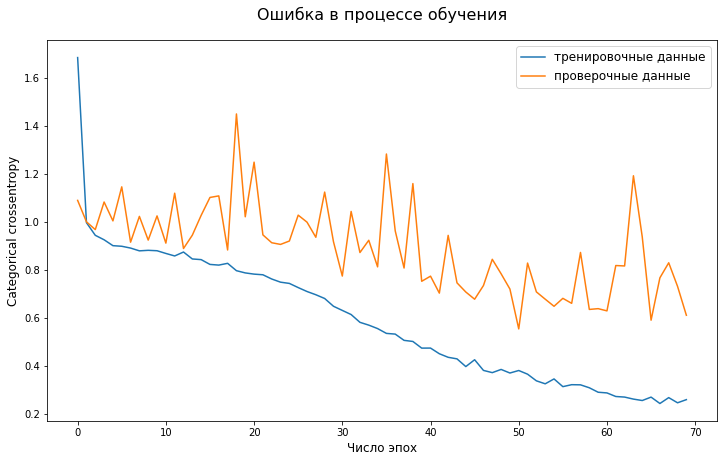

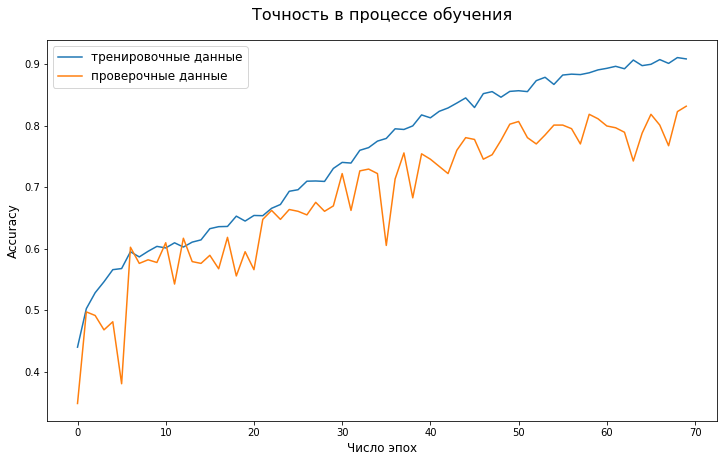

In [ ]:
model_training(conv_model, initial_epoch, epochs, learning_rate, bool_callback)

## **4.) Классификация автомобилей**

In [ ]:
num_img = int(input("Число изображений для анадиза - "))

path_weights = None
use_weights = input("Необходимо ли использовать преобученные веса (Да/Нет) - ")
if (use_weights == "Да"):
  path_weights = input("Путь к весам модели - ")

Число изображений для анадиза - 3
Необходимо ли использовать преобученные веса (Да/Нет) - Нет


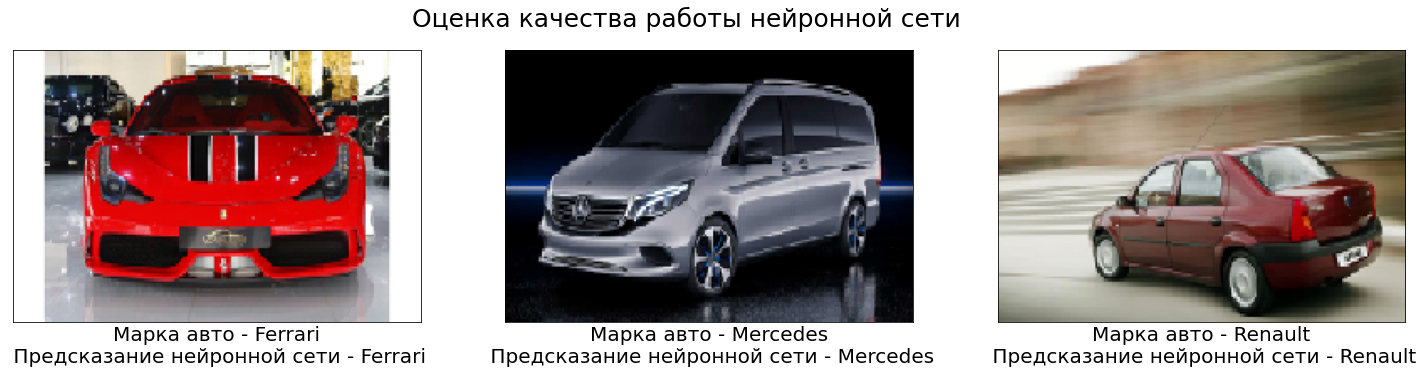

In [ ]:
determine_auto(conv_model, num_img, use_weights, path_weights)

## **5.) Выводы по проделанной работе**

1.   Увеличение числа фильтров на свёрточных слоях Conv2D(...) значительно увеличивает время обучения.

2.   При тестировании нейронной сети данные необходимо подвегать предобратке аналогичной ImageDataGenerator.

3.   В метод *datagen.flow_from_directory* в качестве параметра *target_size* подаётся кортеж *(img_height, img_width)*

4.   Входной слой нейронной сети должен принимать параметры изображения в следующей последовательности *Input(shape=(img_height, img_width, num_chnls))*

5.   Опытным путём были подобраны следующие гиперпараметры:
*   batch_size = 8
*   learning_rate = 1e-4
*   число фильтров на 1-м свёрточном слое = 128
*   количество свёрточных блоков = 4

6.   Как мы видим, нейронная сеть достигла неплохой точности на проверочной выборке (83%). Думаю, можно улучшить данный показатель засчёт дообучения сети с понижением learning rate. 

